In [16]:
from media_impact_monitor.impact import (
    get_impact,
    ImpactSearch,
    correlation,
    time_series_regression,
    interrupted_time_series,
)
from media_impact_monitor.events import get_events, EventSearch
from datetime import date
from media_impact_monitor.trend import get_trend, TrendSearch
import pandas as pd
from IPython.display import display, HTML

organizers = [
    "Fridays for Future",
    "Extinction Rebellion",
    "Last Generation",
    "Greenpeace",
]
# organizers = [organizers[0]]
methods = ["correlation", "time_series_regression", "interrupted_time_series"]
# methods = [methods[0], methods[1]]
start_date = date(2022, 1, 1)
end_date = date(2024, 1, 1)
rows = []
for method in methods:
    trend = get_trend(
        TrendSearch(
            trend_type="keywords",
            media_source="news_print",
            topic="climate_change",
            start_date=start_date,
            end_date=end_date,
        ),
        as_json=False,
    )["climate activism"].rename("count")
    for organizer in organizers:
        events = get_events(
            EventSearch(
                source="acled",
                organizers=[organizer],
                start_date=start_date,
                end_date=end_date,
            )
        )
        aggregation = "daily"
        match method:
            case "correlation":
                row = dict(
                    organizer=organizer,
                    method=method,
                    aggregation=aggregation,
                )
                ts, limitations = correlation(
                    events=events,
                    article_counts=trend,
                )
                row["time_series"] = ts
                rows.append(row)
            case "time_series_regression":
                for lags, ewmas in [
                    ([], []),
                    ([1], []),
                    ([1, 2, 3, 4, 5], []),
                    ([4, 5, 6, 7, 8], []),
                    ([], [1, 7, 28, 84]),
                ]:
                    ts, limitations = time_series_regression(
                        events=events,
                        article_counts=trend,
                        lags=lags,
                    )
                    row = dict(
                        organizer=organizer,
                        method=method,
                        aggregation=aggregation,
                        lags=lags,
                        ewmas=ewmas,
                    )
                    row["rmse"] = ts["rmse"].loc[7]
                    row["rmse_std"] = ts["rmse_std"].loc[7]
                    row["ame"] = ts["ame"].loc[7]
                    row["ame_std"] = ts["ame_std"].loc[7]
                    row["time_series"] = ts
                    rows.append(row)
            case "interrupted_time_series":
                for hidden_days_before_protest in [0, 1]:
                    row = dict(
                        organizer=organizer,
                        method=method,
                        aggregation=aggregation,
                        hidden_days_before_protest=hidden_days_before_protest,
                    )
                    ts, lims = interrupted_time_series(
                        events=events,
                        article_counts=trend,
                        horizon=14,
                        hidden_days_before_protest=hidden_days_before_protest,
                        aggregation=aggregation,
                    )
                    row["time_series"] = ts
                    rows.append(row)

df = pd.DataFrame(rows)


  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

,method,aggregation,lags,ewmas,rmse,rmse_std,ame,ame_std,hidden_days_before_protest,plot
0,correlation,daily,,,,,,,,
4,time_series_regression,daily,[],[],491.892602,180.762406,385.967298,146.391823,,
5,time_series_regression,daily,[1],[],457.138043,116.776018,348.893736,94.522523,,
6,time_series_regression,daily,"[1, 2, 3, 4, 5]",[],435.810535,124.378855,330.716558,93.641693,,
7,time_series_regression,daily,"[4, 5, 6, 7, 8]",[],468.443079,148.940567,367.390495,118.000825,,
8,time_series_regression,daily,[],"[1, 7, 28, 84]",491.892602,180.762406,385.967298,146.391823,,
24,interrupted_time_series,daily,,,,,,,0.0,
25,interrupted_time_series,daily,,,,,,,1.0,

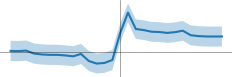
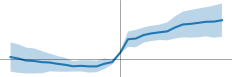
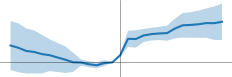
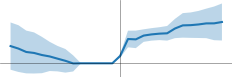
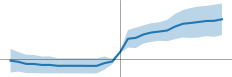
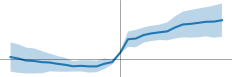
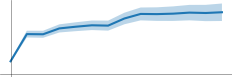
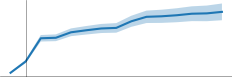

,method,aggregation,lags,ewmas,rmse,rmse_std,ame,ame_std,hidden_days_before_protest,plot
1,correlation,daily,,,,,,,,
9,time_series_regression,daily,[],[],491.38896,177.791276,382.428369,141.95629,,
10,time_series_regression,daily,[1],[],454.511808,117.561048,343.989002,93.794332,,
11,time_series_regression,daily,"[1, 2, 3, 4, 5]",[],429.628916,112.615365,331.158505,91.324255,,
12,time_series_regression,daily,"[4, 5, 6, 7, 8]",[],462.894634,148.798999,367.487993,119.844363,,
13,time_series_regression,daily,[],"[1, 7, 28, 84]",491.38896,177.791276,382.428369,141.95629,,
26,interrupted_time_series,daily,,,,,,,0.0,
27,interrupted_time_series,daily,,,,,,,1.0,

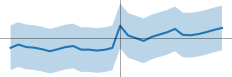
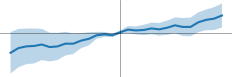
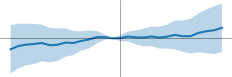
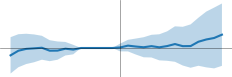
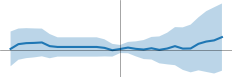
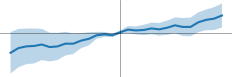
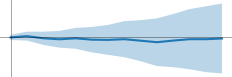
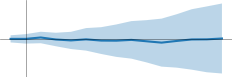

,method,aggregation,lags,ewmas,rmse,rmse_std,ame,ame_std,hidden_days_before_protest,plot
2,correlation,daily,,,,,,,,
14,time_series_regression,daily,[],[],474.627169,196.263822,375.342607,168.524087,,
15,time_series_regression,daily,[1],[],437.122955,154.912264,339.396656,132.026184,,
16,time_series_regression,daily,"[1, 2, 3, 4, 5]",[],418.546416,142.786003,329.454122,119.015727,,
17,time_series_regression,daily,"[4, 5, 6, 7, 8]",[],458.321268,162.593657,360.497655,135.993861,,
18,time_series_regression,daily,[],"[1, 7, 28, 84]",474.627169,196.263822,375.342607,168.524087,,
28,interrupted_time_series,daily,,,,,,,0.0,
29,interrupted_time_series,daily,,,,,,,1.0,

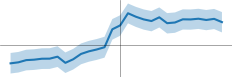
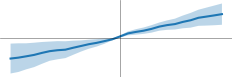
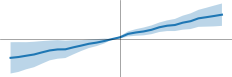
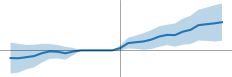
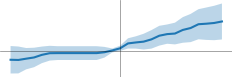
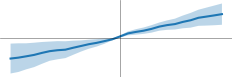
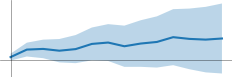
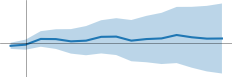

,method,aggregation,lags,ewmas,rmse,rmse_std,ame,ame_std,hidden_days_before_protest,plot
3,correlation,daily,,,,,,,,
19,time_series_regression,daily,[],[],484.532613,167.95496,373.875698,140.808489,,
20,time_series_regression,daily,[1],[],449.418307,119.180753,336.210999,100.578162,,
21,time_series_regression,daily,"[1, 2, 3, 4, 5]",[],428.857044,109.355979,324.261188,88.740428,,
22,time_series_regression,daily,"[4, 5, 6, 7, 8]",[],465.412349,158.015125,365.835799,131.099749,,
23,time_series_regression,daily,[],"[1, 7, 28, 84]",484.532613,167.95496,373.875698,140.808489,,
30,interrupted_time_series,daily,,,,,,,0.0,
31,interrupted_time_series,daily,,,,,,,1.0,

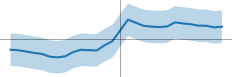
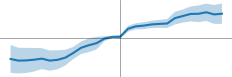
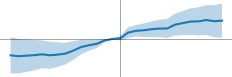
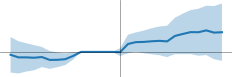
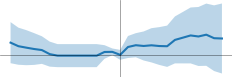
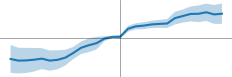
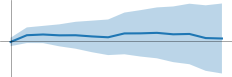
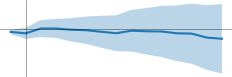

In [17]:
import matplotlib.pyplot as plt
import base64
from io import BytesIO


# Function to create a plot and return it as a base64 encoded string
def create_plot(data):
    fig, ax = plt.subplots(figsize=(3, 1))
    ax.plot(data["mean"])
    if "ci_lower" in data.columns:
        ax.fill_between(
            data.index,
            data["ci_lower"],
            data["ci_upper"],
            alpha=0.3,
        )
    ax.axhline(0, color="black", linewidth=0.5, alpha=0.5)
    ax.axvline(0, color="black", linewidth=0.5, alpha=0.5)
    ax.axis("off")

    buf = BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
    plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode("utf-8")


# Apply the function to create plots
df["plot"] = df["time_series"].apply(create_plot)


# Function to display the image in the notebook
def display_image(img):
    return f'<img src="data:image/png;base64,{img}">'


# # Apply the display function
df["plot"] = df["plot"].apply(display_image)

# Display the DataFrame
from IPython.display import HTML

for organizer in organizers:
    display(HTML(f"<h1>{organizer}</h1>"))
    df_ = df[df["organizer"] == organizer].drop(columns="organizer")
    display(HTML(df_.drop(columns="time_series").fillna("").to_html(escape=False)))
